In [105]:
import os
import sys
import inspect

code_path = os.path.join("/home/kaushalya/Coding/libs/xgboost/python-package")
sys.path.append(code_path)

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV

import xgboost as xgb

import matplotlib.pyplot as plt
import pickle

In [2]:
def classify():
    #TODO implement a general classifier pipeline which can be used for multiple sklearn classifiers
    #TODO save the trained models into files
    return "not implemented"

def get_pr_score(y_test, y_pred, plot=True):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred) #area under PR curve
    
    if plot:
        plt.clf()
        plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.show()
    
    return avg_precision

def get_roc_score(y_test, y_pred, plot=True):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) #area under PR curve
    
    if plot:
        plt.clf()
        plt.plot(fpr, tpr, lw=2, color='navy', label='Precision-Recall curve')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()
    
    return roc_auc

def run_gridsearch(x_train, y_train):
    param_grid = {'n_estimators':[100, 200, 400, 600],
                 'max_features':['auto', 'log2'],
                 'max_depth':[8, 12, 16, 20]}
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1)
    
    cv_clf = GridSearchCV(estimator=clf, scoring='recall', param_grid=param_grid, cv=5, n_jobs=-1)
    cv_clf.fit(x_train, y_train)  
    print(cv_clf.best_params_)
    
    return cv_clf.best_estimator_

In [12]:
if __name__ == "__main__":
    training_rows = range(50000)
    data = pd.read_csv("/home/kaushalya/Coding/wsdm_cup/vandalism/data/features100k_preprocessed_161015_1456.csv",
                       encoding='utf-8', header=0)
    labeled_data_file = "/home/kaushalya/Coding/wsdm_cup/vandalism/data/wikidata-vandalism-corpus-2015/wdvc15-ground-truth.csv"
    labeled_data = pd.read_csv(labeled_data_file, header=0)

In [15]:
    x_train = data.ix[training_rows, data.columns.difference(['revisionId', 'groupId', 'itemId'])]
    y_train = labeled_data.ix[training_rows,'rollback_reverted']
    
    in_test = ~data.index.isin(training_rows)
    x_test = data.ix[in_test,data.columns.difference(['revisionId', 'groupId', 'itemId'])]
    y_test = labeled_data.ix[in_test,'rollback_reverted']

In [24]:
    #TODO feature selection
    
    #running grid search to set parameters of the model
    #clf = run_gridsearch(x_train, y_train)
    
    #clf.fit(x_train, y_train)
    
    #xgb_clf.fit(x_train, y_train, eval_metric='auc')

In [28]:
#gridsearch for XGB
param_test1 = {
 'max_depth':[i for i in range(3,10,2)],
 'min_child_weight':[i for i in range(1,6,2)]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=500, subsample=0.8, 
                                scale_pos_weight=1, seed=23)
gsearch1 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test1, cv=5, n_jobs=-1)
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [102]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.9386182073888142)

In [38]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test2, cv=5, n_jobs=-1)
gsearch2.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [4, 5, 6], 'max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [103]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 6}, 0.9357471239296851)

In [57]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2.best_params_['min_child_weight'], n_estimators=500, subsample=0.8, 
                                scale_pos_weight=1, seed=23)
gsearch2b = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test2b, cv=5, n_jobs=-1)
gsearch2b.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [59]:
gsearch2b.best_params_, gsearch2b.best_score_

{'min_child_weight': 10}

In [63]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
} 
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2b.best_params_['min_child_weight'], n_estimators=500,
                            subsample=0.8, scale_pos_weight=1, seed=23)
gsearch3 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test3, cv=5, n_jobs=-1)
gsearch3.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [82]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.9370839555141003)

In [67]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2b.best_params_['min_child_weight'],
                            gamma=gsearch3.best_params_['gamma'],
                            n_estimators=500,
                            subsample=0.8, scale_pos_weight=1, seed=23)
gsearch4 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test4, cv=5, n_jobs=-1)
gsearch4.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [69]:
gsearch4.best_params_, gsearch4.best_score_

{'colsample_bytree': 0.7, 'subsample': 0.6}

In [73]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2b.best_params_['min_child_weight'],
                            gamma=gsearch3.best_params_['gamma'], 
                            colsample_bytree=gsearch4.best_params_['colsample_bytree'],
                            subsample=gsearch4.best_params_['subsample'],
                            n_estimators=500,
                            scale_pos_weight=1, seed=23)
gsearch5 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test5, cv=5, n_jobs=-1)
gsearch5.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.6),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [81]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.9430784377508672)

In [79]:
param_test6 = {
 'reg_alpha':[1e-6, 1e-5, 1e-4, 0.0005]
}
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2b.best_params_['min_child_weight'],
                            gamma=gsearch3.best_params_['gamma'], 
                            colsample_bytree=gsearch4.best_params_['colsample_bytree'],
                            subsample=gsearch4.best_params_['subsample'],
                            n_estimators=500,
                            scale_pos_weight=1, seed=23)
gsearch6 = GridSearchCV(estimator=xgb_clf, scoring='roc_auc', param_grid=param_test6, cv=5, n_jobs=-1)
gsearch6.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.6),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [1e-06, 1e-05, 0.0001, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [87]:
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0.0005}, 0.9431158425401045)

In [92]:
#reducing the learning rate and adding more trees to the model
clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=gsearch2.best_params_['max_depth'],
                            min_child_weight=gsearch2b.best_params_['min_child_weight'],
                            gamma=gsearch3.best_params_['gamma'], 
                            colsample_bytree=gsearch4.best_params_['colsample_bytree'],
                            subsample=gsearch4.best_params_['subsample'],
                            n_estimators=1000,
                            learning_rate=0.01,
                            reg_alpha=gsearch6.best_params_['reg_alpha'],
                            scale_pos_weight=1, seed=23)
clf.fit(x_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=10, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0005, reg_lambda=1,
       scale_pos_weight=1, seed=23, silent=True, subsample=0.6)

accuracy: 0.984840


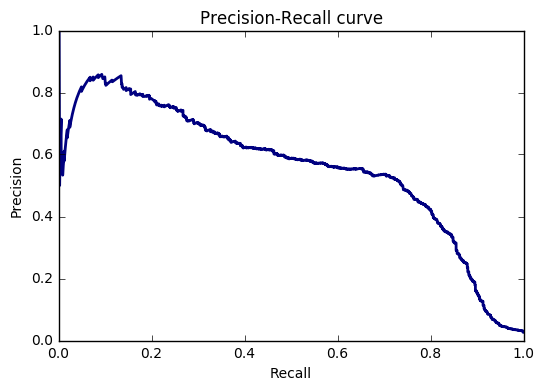

area under PR curve: 0.557080
logloss score: 0.043031


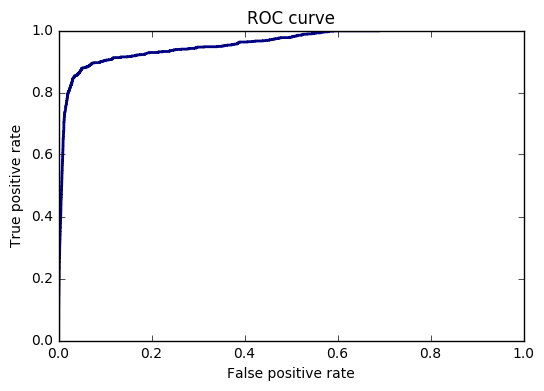

ROC-AUC score: 0.957964


In [119]:
    y_pred_prob = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)

    print("accuracy: %f"%accuracy_score(y_test, y_pred))
    print("area under PR curve: %f"%get_pr_score(y_test, y_pred_prob[:,1]))
    print("logloss score: %f"%log_loss(y_test, y_pred_prob))
    print("ROC-AUC score: %f"%get_roc_score(y_test, y_pred_prob[:,1]))

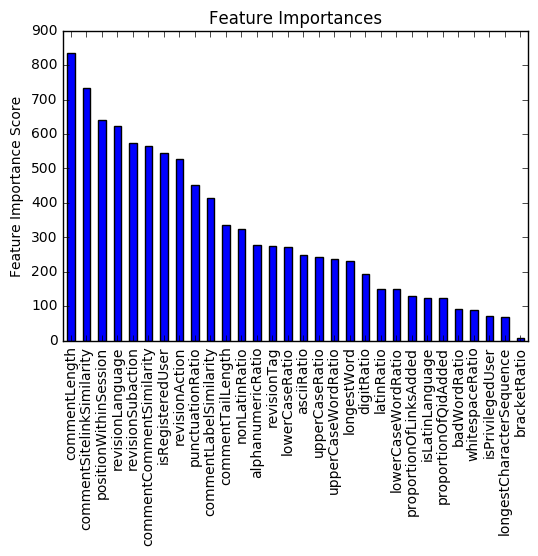

In [96]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [104]:
print("number of features used in the GBM: %d"%feat_imp.shape[0])

number of features used in the GBM: 30
